### モジュールのインポートとパラメータの設定

In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from pathlib import Path
from openpyxl import Workbook

SEED = 42
CCP_ALPHA = 0.01
CRITERION = "entropy"
MAX_DEPTH = 3
MAX_FEATURES = "sqrt"
N_ESTIMATORS = 100
THRESHOLD_SPECIFICITY = 0.93
DATA_MODE = "raw"

### 機械学習モデルの構築

In [28]:
# トレーニングデータの読み込み
df_train = pd.read_csv(f"train_{DATA_MODE}.csv")
features = ["DPP4/FAP", "CTRB2", "CTRB1/CTRB2", "CELA3A"]
train_X = df_train[features]
train_y = df_train["label"].apply(lambda x: 1 if x == "PC" else 0)

# モデルの学習、構築
model = RandomForestClassifier(
    random_state=SEED,
    ccp_alpha=CCP_ALPHA,
    criterion=CRITERION,
    max_depth=MAX_DEPTH,
    max_features=MAX_FEATURES,
    n_estimators=N_ESTIMATORS,
)
model.fit(train_X, train_y)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'entropy'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",3
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

    sample_name label  DPP4/FAP     CTRB2  CTRB1/CTRB2    CELA3A     score
0          A001     C  0.419946  0.004087     0.342640  0.000351  0.035011
1          A002     C  0.558765  0.006930     0.278107  0.001001  0.061817
2          A003    PC  0.795238  0.003007     0.186788  0.000045  0.835080
3          A004     C  0.623253  0.005285     0.280765  0.000753  0.140893
4          A005     C  0.575033  0.004811     0.250827  0.001010  0.065350
..          ...   ...       ...       ...          ...       ...       ...
176        E047     C  0.628721  0.003371     0.303965  0.000601  0.161813
177        E048     C  0.619803  0.003411     0.368213  0.000875  0.108943
178        E049     C  0.552061  0.001429     0.551282  0.000279  0.047464
179        E050     C  0.690026  0.000922     0.620462  0.000625  0.351642
180        E051     C  0.591514  0.009635     0.206206  0.000836  0.406717

[181 rows x 7 columns]


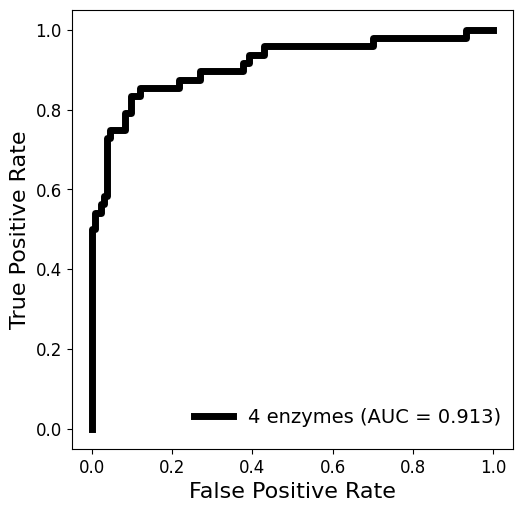

0.36952900646483366


In [29]:
# テストデータの読み込みとスコア出力・AUC計算
df_test = pd.read_csv(f"test_{DATA_MODE}.csv")
test_X = df_test[features]
test_y = df_test["label"].apply(lambda x: 1 if x == "PC" else 0)

# 各列についてスコアを計算、"score"列を新しく作って格納
y_pred = model.predict_proba(test_X)[:, 1]
df_test["score"] = y_pred
print(df_test)

# 書き出したモデルのテスト用にCSVを保存
df_test.to_csv(f"test_{DATA_MODE}_with_scores.csv", index=False)

# AUC計算とROC曲線のプロット
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
auc_roc = roc_auc_score(test_y, y_pred)
y_label = np.array(test_y)
threshold_1 = min(thresholds[np.where(1 - fpr == np.min(1 - fpr[1 - fpr > THRESHOLD_SPECIFICITY]))[0]])

plt.figure(figsize=(5.7, 5.7))
plt.plot(
    fpr, tpr, color="black", label=r"4 enzymes (AUC = %0.3f)" % (auc_roc), lw=5, alpha=1
)

plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.legend(
    loc="upper left",
    bbox_to_anchor=(0.25, 0.12),
    fontsize=14,
    frameon=False,
    borderpad=0.1,
)

plt.tick_params(labelsize=12)
plt.show()
print(threshold_1)

### 構築した機械学習モデルをエクセルシートに保存

In [30]:
# 機械学習モデルのエクセルシートを出力する

# --- 設定 ---
OUT_XLSX  = Path(f'random_forest_calculator_{DATA_MODE}.xlsx')
CELL_REF  = {
    "DPP4/FAP": "$B$2",
    "CTRB2": "$B$3",
    "CTRB1/CTRB2": "$B$4",
    "CELA3A": "$B$5",
}
rf = model.fit(train_X, train_y)

# --- 1本の木 → Excel IF 式 ---
def _fmt(x, d=10):
    s = f"{float(x):.{d}f}"; s = s.rstrip('0').rstrip('.') if '.' in s else s
    return s

def tree_to_if_formula(est):
    t = est.tree_
    def rec(n:int)->str:
        if t.children_left[n] == t.children_right[n]:  # leaf
            cnt = t.value[n][0]
            p = (cnt[1]/cnt.sum()) if cnt.sum() else 0.0
            return _fmt(p)
        i = t.feature[n]; thr = t.threshold[n]
        feat = features[i]
        left = rec(t.children_left[n]); right = rec(t.children_right[n])
        return f"IF({CELL_REF[feat]}<={_fmt(thr)},{left},{right})"
    return "=" + rec(0)

# --- Excel 生成（最小構成）---
wb = Workbook(); ws = wb.active; ws.title = "RF"
ws["A1"] = "Feature"; ws["B1"] = "Value"
ws["A2"] = "DPP4_FAP (= DPP4/FAP)"  # 入力は B2..B5
ws["A3"] = "CTRB2"
ws["A4"] = "Chymotrypsin (= CTRB1/CTRB2)"
ws["A5"] = "CELA3A"
ws["A6"] = "Score (mean of trees)"  # 最終スコアは B6
ws["A7"] = "Per-tree P(y=1)"        # 以降に各木

start_row = 8
for idx, est in enumerate(rf.estimators_, start=1):
    r = start_row + idx - 1
    ws[f"A{r}"] = idx
    ws[f"B{r}"] = tree_to_if_formula(est)

end_row = start_row + len(rf.estimators_) - 1
ws["B6"] = f"=AVERAGE($B${start_row}:$B${end_row})"

wb.save(OUT_XLSX)
OUT_XLSX

WindowsPath('random_forest_calculator_raw.xlsx')

In [31]:
# 各木の閾値についてパラメータごとの最大値・最小値を計算
threshold_stats = {feature: {"min": float('inf'), "max": float('-inf'), "values": []} for feature in features}

for est in rf.estimators_:
    t = est.tree_
    for node_idx in range(t.node_count):
        if t.children_left[node_idx] != t.children_right[node_idx]:  # internal node
            feature_idx = t.feature[node_idx]
            threshold_val = t.threshold[node_idx]
            feature_name = features[feature_idx]
            
            threshold_stats[feature_name]["values"].append(threshold_val)
            threshold_stats[feature_name]["min"] = min(threshold_stats[feature_name]["min"], threshold_val)
            threshold_stats[feature_name]["max"] = max(threshold_stats[feature_name]["max"], threshold_val)

# 結果をDataFrameで整形して表示
threshold_df = pd.DataFrame([
    {
        "Feature": feature,
        "Min Threshold": stats["min"],
        "Max Threshold": stats["max"],
        "Count": len(stats["values"])
    }
    for feature, stats in threshold_stats.items()
])

print("=" * 60)
print("各パラメータの閾値統計")
print("=" * 60)
print(threshold_df.to_string(index=False))
print("=" * 60)

各パラメータの閾値統計
    Feature  Min Threshold  Max Threshold  Count
   DPP4/FAP       0.405825       0.783803    135
      CTRB2       0.001202       0.031374    152
CTRB1/CTRB2       0.087942       0.666175    143
     CELA3A       0.000110       0.004503    107
